<a href="https://colab.research.google.com/github/lannaelvira77/WeatherWise-LannaElvira-23486942/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise: Intelligent Weather Analysis & Advisory System

Welcome to your **WeatherWise** project notebook!



## 🧰 Setup and Imports


In [2]:
# matplotlib for temperature and precipitation visualisations
# pyinputplus for console-style user interface (menu input validation)

!pip install matplotlib pyinputplus


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyinputplus: filename=pyinputplus-0.2.12-py3-none-any.whl size=11348 sha256=32aa6d59f7263bd01f5b214c5bebc6c8d72c9a14f400b01cc1c73dde2a0b9308
  Stored in directory: /root/.cache/pip/wheels/85/81/c1/325c8199c5c4de8a0b9af900ff9cd8bd69853e3d9419493512
  Created wheel for pysimplevalidate: filename=pysimplevalidate-0.2.12-py3-none-any.whl size=16225 sha256=fac8b13e99e9e44e4b931a81a79d2cc7875ea9b943b482369c24d23daa2d16d3
  Stored in directory: /root/.cache/pip/wheels/09/de/18/4dd2be0dbdf31870c6f0abde43b0de197b1c095655ad7da5c2
  Created wheel for stdiomask: filename=stdiomask

In [3]:
# ntlk for more advanced NLP

!pip install nltk

## 📦 Setup and Configuration

In [16]:
import os
os.environ['OWM_API_KEY'] = "3940901d1d76b912b0cd840fd2b06ff7"

api_key = os.environ['OWM_API_KEY']

In [18]:
# Store and Test the Connection to OpenWeatherMap API

import requests

# API Key
api_key = "3940901d1d76b912b0cd840fd2b06ff7"

# Test the Location
location = "Perth,AU"

# Build the API request URL
url = f"http://api.openweathermap.org/data/2.5/weather?q={location}&appid={api_key}&units=metric"

# Send the request
response = requests.get(url)

# Convert to JSON
data = response.json()

# Display result
print(data)

{'coord': {'lon': 115.8333, 'lat': -31.9333}, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10n'}], 'base': 'stations', 'main': {'temp': 14.23, 'feels_like': 13.85, 'temp_min': 13.8, 'temp_max': 14.48, 'pressure': 1016, 'humidity': 82, 'sea_level': 1016, 'grnd_level': 1014}, 'visibility': 10000, 'wind': {'speed': 2.57, 'deg': 150}, 'rain': {'1h': 0.22}, 'clouds': {'all': 0}, 'dt': 1759589045, 'sys': {'type': 2, 'id': 63154, 'country': 'AU', 'sunrise': 1759528243, 'sunset': 1759573200}, 'timezone': 28800, 'id': 2063523, 'name': 'Perth', 'cod': 200}


## 🌤️ Weather Data Functions

This function will:
1. Retrieve current weather and 5-day forecast from OpenWeatherMap API (v2.5)
2. Convert the JSON response into a clean dictionary
3. Error handling: invalid city names, network errors, and forecast limit (1-5 days)
4. Good modular structure

In [118]:
import os, requests
from datetime import datetime, timezone
from collections import defaultdict
import time

_WEATHER_CACHE = {}
_CACHE_TTL_SECONDS = 600  # 10 minutes
_RETRY_STATUS = {502, 503, 504}  # transient
_DEFAULT_TIMEOUT = 20

def _now_utc():
    return datetime.now(timezone.utc)

def _make_error(message, code=None, hint=None):
    """Standard error payload the UI can render."""
    return {"error": {"message": message, "code": code, "hint": hint}}

def _safe_get(d, path, default=None):
    cur = d
    for p in path:
        if not isinstance(cur, dict) or p not in cur:
            return default
        cur = cur[p]
    return cur

def _aggregate_daily_from_3h(forecast_json, forecast_days):
    three_hour_list = forecast_json.get("list", [])
    buckets = defaultdict(list)
    tz_offset = forecast_json.get("city", {}).get("timezone", 0)
    for item in three_hour_list:
        dt_txt = item.get("dt_txt")  # 'YYYY-MM-DD HH:MM:SS' in UTC
        if not dt_txt:
            continue

        try:
            dt_obj = datetime.strptime(dt_txt, "%Y-%m-%d %H:%M:%S")
            # Convert to local time using the timezone offset
            local_dt = dt_obj + timedelta(seconds=tz_offset)
            day = local_dt.strftime("%Y-%m-%d")
        except Exception:
            # Fallback to UTC date if parsing fails
            day = dt_txt.split(" ")[0]

        buckets[day].append(item)

    daily_rows = []
    for day in sorted(buckets.keys()):
        rows = buckets[day]
        temps = [_safe_get(x, ["main","temp"]) for x in rows if _safe_get(x, ["main","temp"]) is not None]
        pops  = [x.get("pop") for x in rows if isinstance(x.get("pop"), (int, float))]
        descs = [_safe_get(x, ["weather"], [{}])[0].get("description") for x in rows if _safe_get(x, ["weather"], [{}])]
        icons = [_safe_get(x, ["weather"], [{}])[0].get("icon") for x in rows if _safe_get(x, ["weather"], [{}])]
        if not temps:
            continue
        temp_min, temp_max = min(temps), max(temps)
        temp_avg = sum(temps) / len(temps)
        pop_avg = (sum(pops) / len(pops) * 100.0) if pops else 0.0

        def _most_common(lst):
            if not lst: return None
            c = {}
            for v in lst: c[v] = c.get(v, 0) + 1
            return max(c, key=c.get)

        description = (_most_common([d for d in descs if d]) or (descs[0] if descs else "") or "").capitalize()
        icon = _most_common([i for i in icons if i]) or (icons[0] if icons else "")

        daily_rows.append({
            "date": day,
            "temp_min": round(temp_min, 2),
            "temp_max": round(temp_max, 2),
            "temp_avg": round(temp_avg, 2),
            "pop": round(pop_avg, 1),
            "description": description,
            "icon": icon
        })
    return daily_rows[:max(1, min(int(forecast_days), 5))]

def _http_get_with_retry(url, params, timeout=_DEFAULT_TIMEOUT, retries=1):
    """Tiny retry for transient 5xx."""
    for attempt in range(retries + 1):
        try:
            r = requests.get(url, params=params, timeout=timeout)
            return r
        except requests.exceptions.RequestException as e:
            if attempt >= retries:
                raise
            time.sleep(0.8)  # backoff
    # unreachable
    return None

def get_weather_data(location, forecast_days=5, include_hourly_24h=True, use_cache=True):
    """
    Retrieve weather data (OpenWeatherMap v2.5) and return a hybrid-friendly dict.

    Returns either a data dict or {"error": {...}} for the UI to render nicely.
    """
    # ---- Input validation ----
    if not isinstance(location, str) or not location.strip():
        return _make_error("Please provide a city name (e.g., 'Perth,AU').", code="bad_input")
    location = location.strip()
    try:
        forecast_days = int(forecast_days)
    except Exception:
        return _make_error("forecast_days must be an integer between 1 and 5.", code="bad_input")
    if not (1 <= forecast_days <= 5):
        return _make_error("forecast_days must be between 1 and 5.", code="bad_input")

    api_key = os.environ.get("OWM_API_KEY")
    if not api_key:
        return _make_error("Missing API key. Set OWM_API_KEY.", code="missing_api_key",
                           hint="In Colab: os.environ['OWM_API_KEY'] = '...your key...'")

    base_url_current = "https://api.openweathermap.org/data/2.5/weather"
    base_url_forecast = "https://api.openweathermap.org/data/2.5/forecast"
    params = {"q": location, "appid": api_key, "units": "metric"}

    # ---- Cache ----
    cache_key = (location.lower(), forecast_days)
    if use_cache and cache_key in _WEATHER_CACHE:
        cached = _WEATHER_CACHE[cache_key]
        if (_now_utc() - cached["fetched_at"]).total_seconds() < _CACHE_TTL_SECONDS:
            return cached["data"]

    # ---- API calls with graceful errors ----
    try:
        cur_res = _http_get_with_retry(base_url_current, params, retries=1)
        if cur_res.status_code in _RETRY_STATUS:
            cur_res = _http_get_with_retry(base_url_current, params, retries=1)
        if cur_res.status_code == 401:
            return _make_error("Invalid API key (401). Check OWM_API_KEY.", code=401)
        if cur_res.status_code == 404:
            return _make_error(f"City not found: '{location}'.", code=404,
                               hint="Try 'City,CountryCode' e.g., 'Perth,AU'.")
        if cur_res.status_code == 429:
            return _make_error("Rate limit exceeded (429). Please try again shortly.", code=429)
        cur_res.raise_for_status()

        fct_res = _http_get_with_retry(base_url_forecast, params, retries=1)
        if fct_res.status_code in _RETRY_STATUS:
            fct_res = _http_get_with_retry(base_url_forecast, params, retries=1)
        fct_res.raise_for_status()

    except requests.exceptions.Timeout:
        return _make_error("The weather service timed out. Please try again.", code="timeout")
    except requests.exceptions.RequestException as e:
        return _make_error(f"Network error: {e}", code="network")

    # ---- Parse JSON, handle provider-level errors ----
    cur_json = cur_res.json()
    fct_json = fct_res.json()

    # Sometimes OWM returns {"cod":"404", ...} even with 200 HTTP
    cod = cur_json.get("cod")
    if str(cod) != "200":
        return _make_error(cur_json.get("message", "Unknown error from provider."), code=cod)

    fetched_at = _now_utc().isoformat()
    loc_name = cur_json.get("name", location)
    loc_country = _safe_get(cur_json, ["sys","country"], "")
    lat = _safe_get(cur_json, ["coord","lat"])
    lon = _safe_get(cur_json, ["coord","lon"])
    tz_seconds = _safe_get(cur_json, ["timezone"], 0)

    weather0 = _safe_get(cur_json, ["weather"], [{}])[0] or {}
    current = {
        "temp": round(_safe_get(cur_json, ["main","temp"], 0.0), 2),
        "description": weather0.get("description", "").capitalize(),
        "humidity": _safe_get(cur_json, ["main","humidity"], 0),
        "wind_speed": _safe_get(cur_json, ["wind","speed"], 0.0),
        "icon": weather0.get("icon", ""),
        "sunrise": _safe_get(cur_json, ["sys","sunrise"]),
        "sunset": _safe_get(cur_json, ["sys","sunset"]),
    }
    current["summary"] = f"{current['temp']}°C, {current['description']} (Humidity {current['humidity']}%, Wind {current['wind_speed']} m/s)"

    daily = _aggregate_daily_from_3h(fct_json, forecast_days)

    hourly_24h = None
    if include_hourly_24h:
        slots = (fct_json.get("list") or [])[:8]
        hourly_24h = []
        for it in slots:
            w0 = _safe_get(it, ["weather"], [{}])[0] or {}
            hourly_24h.append({
                "dt": it.get("dt_txt"),
                "temp": round(_safe_get(it, ["main","temp"], 0.0), 2),
                "pop": round((it.get("pop") or 0) * 100.0, 1),
                "description": (w0.get("description") or "").capitalize(),
                "icon": w0.get("icon", "")
            })

    data = {
        "meta": {"provider": "OpenWeatherMap", "fetched_at_utc": fetched_at, "units": "metric"},
        "location": {"query": location, "name": loc_name, "country": loc_country, "lat": lat, "lon": lon,
                     "timezone_offset_seconds": tz_seconds},
        "current": current,
        "daily": daily,
    }
    if hourly_24h is not None:
        data["hourly_24h"] = hourly_24h

    if use_cache:
        _WEATHER_CACHE[cache_key] = {"data": data, "fetched_at": _now_utc()}

    return data

# Optional helpers for your UI/tests
def weather_cache_info():
    return {"entries": len(_WEATHER_CACHE), "ttl_seconds": _CACHE_TTL_SECONDS}

def weather_cache_clear():
    _WEATHER_CACHE.clear()


#Test The Functions
import json

# Happy path
ok = get_weather_data("Perth,AU", 3)
print(json.dumps(ok, indent=2)[:600], "...")

# Bad city
bad = get_weather_data("NoSuchCityZZ,AU", 3)
print(bad)

# Bad forecast_days
bad_days = get_weather_data("Perth,AU", 9)
print(bad_days)

{
  "meta": {
    "provider": "OpenWeatherMap",
    "fetched_at_utc": "2025-10-04T17:11:31.055629+00:00",
    "units": "metric"
  },
  "location": {
    "query": "Perth,AU",
    "name": "Perth",
    "country": "AU",
    "lat": -31.9333,
    "lon": 115.8333,
    "timezone_offset_seconds": 28800
  },
  "current": {
    "temp": 14.13,
    "description": "Light rain",
    "humidity": 82,
    "wind_speed": 1.54,
    "icon": "10n",
    "sunrise": 1759614565,
    "sunset": 1759659640,
    "summary": "14.13\u00b0C, Light rain (Humidity 82%, Wind 1.54 m/s)"
  },
  "daily": [
    {
      "date": "2025-1 ...
{'error': {'message': "City not found: 'NoSuchCityZZ,AU'.", 'code': 404, 'hint': "Try 'City,CountryCode' e.g., 'Perth,AU'."}}
{'error': {'message': 'forecast_days must be between 1 and 5.', 'code': 'bad_input', 'hint': None}}


In [20]:
# ===== Extensions: Historical data scaffolding =====
def get_historical_weather_data(location: str, start_date: str, days: int = 3):
    """
    Historical weather data (scaffold).
    Replace with a real provider (e.g., OWM history, Meteostat) when ready.
    Returns {"error": {...}} for now to keep UI stable.
    """
    ok, note = validate_location_format(location)
    if not ok:
        return {"error": {"message": note, "code": "bad_input"}}
    try:
        _ = datetime.strptime(start_date, "%Y-%m-%d")
    except Exception:
        return {"error": {"message": "start_date must be 'YYYY-MM-DD'.", "code": "bad_input"}}

    return {
        "error": {
            "message": "Historical provider not configured yet.",
            "code": "not_implemented",
            "hint": "Connect a history API and map it to the same structure as get_weather_data()."
        }
    }

## Shared Validators & Data Helpers

In [21]:
# ===== Extensions: Shared helpers =====
import re
from datetime import datetime, timedelta, timezone

def validate_location_format(loc: str) -> tuple[bool, str | None]:
    """
    Basic sanity check for 'City' or 'City,CC' (CC=country code).
    We keep it permissive; API will still be the source of truth.
    """
    if not isinstance(loc, str) or not loc.strip():
        return False, "Please enter a non-empty city name (e.g., 'Perth,AU')."
    loc = loc.strip()
    if len(loc) < 2:
        return False, "City name seems too short."
    # Allow letters, spaces, hyphens, dots, apostrophes, comma + 2-letter CC
    if not re.match(r"^[A-Za-z .'\-]+(,\s*[A-Za-z]{2})?$", loc):
        return True, "Note: unusual city format; attempting lookup anyway."
    return True, None

def daterange(start_date: datetime, days: int):
    for i in range(days):
        yield start_date + timedelta(days=i)

# ===== Extensions: Activity recommendation (e.g., hiking) =====
def score_hiking_day(day: dict) -> tuple[int, list[str]]:
    """
    Score a day (0-100) for hiking using simple heuristics:
      - Too hot/cold reduces score
      - Rain chance reduces score
      - Moderate wind is fine; very windy reduces
    """
    reasons = []
    score = 100

    t_avg = day.get("temp_avg")
    t_min = day.get("temp_min")
    t_max = day.get("temp_max")
    pop   = day.get("pop", 0.0)           # %
    # Wind not available per-day in free OWM feed—leave note
    windy = None

    # Temperature comfort band
    if t_avg is not None:
        if t_avg < 5:   score -= 35; reasons.append("very cold")
        elif t_avg < 12: score -= 15; reasons.append("cool")
        elif t_avg > 35: score -= 30; reasons.append("extreme heat")
        elif t_avg > 30: score -= 15; reasons.append("hot")

    # Precipitation
    if pop >= 70: score -= 40; reasons.append("high rain chance")
    elif pop >= 40: score -= 20; reasons.append("possible showers")

    # Wind (not daily here). If you later add daily wind, apply it:
    # if wind_speed and wind_speed > 10: score -= 15; reasons.append("windy")

    # Clamp
    score = max(0, min(100, score))
    return score, reasons

def recommend_activity(weather_data: dict, activity: str = "hiking", days: int | None = None) -> str:
    """
    Return a short human-readable recommendation summary for the next N days.
    For now only 'hiking' has scoring logic; easily extended for others.
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        return "I can't assess activities right now due to missing weather data."

    daily = weather_data.get("daily") or []
    if not daily:
        return "No multi-day forecast available to make a recommendation."

    k = max(1, min(days or len(daily), len(daily)))
    daily = daily[:k]

    if activity.lower() != "hiking":
        return f"I don't have a model for {activity} yet—try 'hiking'."

    lines = []
    best = None
    for d in daily:
        score, reasons = score_hiking_day(d)
        tag = "✅ Good" if score >= 75 else ("⚠️ Fair" if score >= 50 else "❌ Poor")
        reason_txt = (", ".join(reasons) if reasons else "conditions look fine")
        lines.append(f"{d['date']}: {tag} ({score}/100) — {reason_txt}")
        best = max(best or (score, d['date']), (score, d['date']))

    summary = f"Recommendation for hiking in {weather_data['location']['name']} (next {k} days):\n" + "\n".join("- " + x for x in lines)
    if best:
        summary += f"\n\nBest day: {best[1]} (score {best[0]}/100)."
    return summary

# ===== Extensions: Calendar integration stubs =====
def is_day_good_for_event(weather_data: dict, target_date: str, activity="outdoor"):
    """
    Check a specific date in the 'daily' forecast and return a simple verdict string.
    """
    daily = (weather_data or {}).get("daily") or []
    for d in daily:
        if d.get("date") == target_date:
            # very simple: if rain chance < 40% and not extreme heat/cold
            pop = d.get("pop", 0)
            t = d.get("temp_avg", 20)
            ok_temp = 8 <= t <= 32
            verdict = (pop < 40 and ok_temp)
            return verdict, f"{'Good' if verdict else 'Not ideal'} for {activity.lower()} — {t:.0f}°C, rain {pop:.0f}%."
    return None, "That date is not in the current forecast window."

def add_event_placeholder(title: str, date_str: str, location: str):
    """
    Placeholder for calendar integration: in real use, push to Google Calendar API or save .ics.
    """
    return f"(Stub) Would add event '{title}' on {date_str} for {location}."

## 📊 Visualisation Functions

In [22]:
# ---- Visualisation theme helpers ----
DEFAULT_THEME = {
    "temp_line": "orange",
    "hourly_line": "orange",
    "rain_bar": "skyblue",
    "tmin_line": "blue",
    "tmax_line": "red",
    "bar_edge": "black",
    "grid_alpha": 0.6,
}

def apply_theme_color(theme: dict | None, key: str, fallback: str | None = None):
    """Return themed color if provided, otherwise the fallback."""
    if isinstance(theme, dict) and key in theme:
        return theme[key]
    return fallback

### Temperature Trend Visualisation

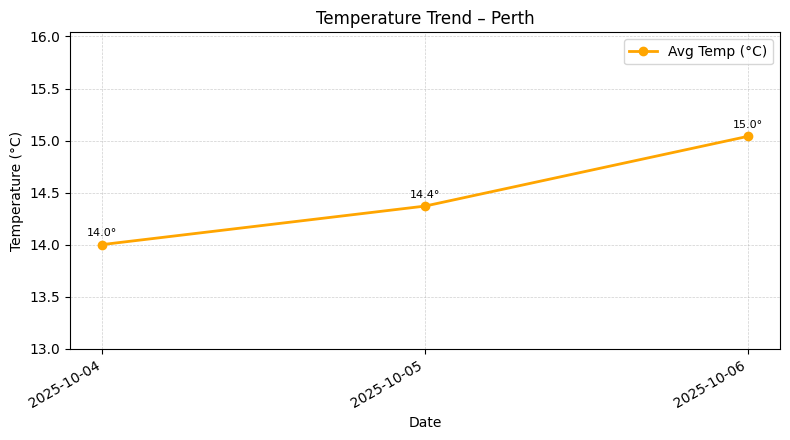

In [57]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_temperature_visualisation(weather_data, output_type='display', theme=None):
    """
    Create a visualisation of the temperature trend over the forecast period.
    Line chart of daily average temperature with labels, legend, and guards.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected daily structure (preferred):
                weather_data["daily"] = [
                    {"date":"YYYY-MM-DD","temp_avg":float,"temp_min":float,"temp_max":float, ...}, ...
                ]
            Fallback (simpler schema):
                weather_data["forecast"] = [
                    {"date":"YYYY-MM-DD","temp":float, ...}, ...
                ]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    # ---- Guards ----
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"

    # Prefer enhanced schema
    daily = weather_data.get("daily") or []
    dates, temps = [], []
    if daily:
        for row in daily:
            d = row.get("date")
            t = row.get("temp_avg", row.get("temp"))
            if d is None or t is None:
                continue
            dates.append(d)
            temps.append(float(t))
    else:
        # Fallback simple schema
        for row in weather_data.get("forecast", []):
            d, t = row.get("date"), row.get("temp")
            if d is None or t is None:
                continue
            dates.append(d); temps.append(float(t))

    if not dates or not temps:
        print("ℹ️ No temperature data available.")
        return None

    # Ensure chronological order
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), t) for d, t in zip(dates, temps)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _ in pairs]
        temps = [t for _, t in pairs]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(8, 4.5))
    color = apply_theme_color(theme, "temp_line", "orange")
    ax.plot(dates, temps, marker='o', linewidth=2, color=color, label="Avg Temp (°C)")
    ax.set_title(f"Temperature Trend – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=apply_theme_color(theme, "grid_alpha", 0.6))
    ax.legend(loc="best")

    # Annotate points
    for x, y in zip(dates, temps):
        ax.annotate(f"{y:.1f}°", xy=(x, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=8)

    # Y padding for extremes
    ymin, ymax = min(temps), max(temps)
    if ymin == ymax:
        ymin -= 2; ymax += 2
    ax.set_ylim(ymin - 1.0, ymax + 1.0)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show(block=False); plt.close(fig); return None

# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_temperature_visualisation(data)                 # displays chart

### Precipitation Probability Visualisation



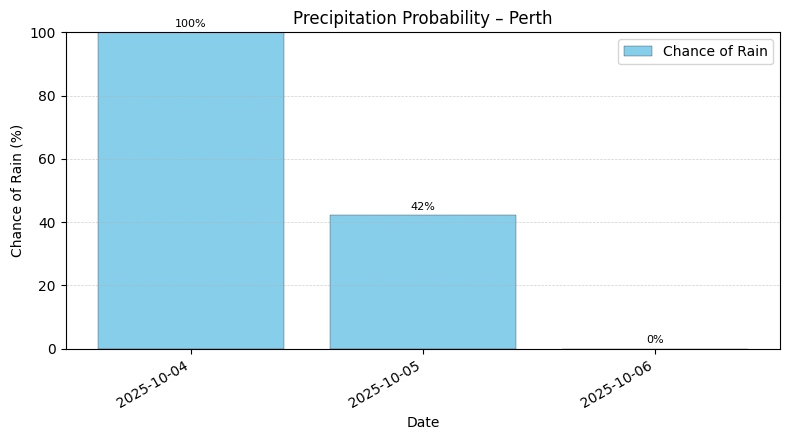

In [60]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_precipitation_visualisation(weather_data, output_type='display', theme=None):
    """
    Create a visualisation of daily precipitation (rain) probability over the forecast period.
    Bar chart of % chance of rain (POP) with legend, labels, edge cases.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected daily structure:
                weather_data["daily"] = [
                    {"date":"YYYY-MM-DD","pop":float, ...}, ...
                ]
            Fallback structure:
                weather_data["forecast"] = [
                    {"date":"YYYY-MM-DD","description":str}, ...
                ]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"

    dates, pops = [], []
    daily = weather_data.get("daily") or []
    if daily:
        for row in daily:
            d, p = row.get("date"), row.get("pop")
            if d is None or p is None:
                continue
            dates.append(d); pops.append(float(p))
    else:
        # Fallback heuristic if only descriptions exist
        for row in weather_data.get("forecast", []):
            d = row.get("date"); desc = (row.get("description") or "").lower()
            if not d: continue
            if "rain" in desc or "shower" in desc: prob = 60.0
            elif "cloud" in desc: prob = 30.0
            else: prob = 10.0
            dates.append(d); pops.append(prob)

    if not dates or not pops:
        print("ℹ️ No precipitation data available for this period.")
        return None

    # Sort chronologically
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), p) for d, p in zip(dates, pops)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _ in pairs]
        pops = [p for _, p in pairs]
    except Exception:
        pass

    if sum(pops) == 0:
        print("ℹ️ Precipitation probability is 0% across the selected days.")
        # Still show a flat chart for clarity
    fig, ax = plt.subplots(figsize=(8, 4.5))
    bar_color  = apply_theme_color(theme, "rain_bar", "skyblue")
    edge_color = apply_theme_color(theme, "bar_edge", "black")
    ax.bar(dates, pops, label="Chance of Rain", color=bar_color, edgecolor=edge_color, linewidth=0.2)
    ax.set_title(f"Precipitation Probability – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of Rain (%)")
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=apply_theme_color(theme, "grid_alpha", 0.6))
    ax.legend(loc="best")

    for i, v in enumerate(pops):
        ax.text(i, v + 1, f"{v:.0f}%", ha='center', va='bottom', fontsize=8)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show(block=False); plt.close(fig); return None


# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_precipitation_visualisation(data)

### Temperature Range Visualisation

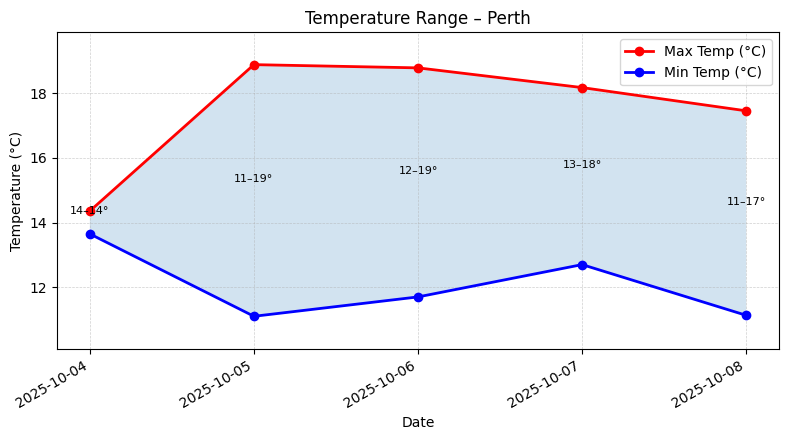

In [61]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_temperature_range_visualisation(weather_data, output_type='display', theme=None):
    """
    Create a visualisation showing the daily minimum and maximum temperatures
    over the forecast period, with a shaded range area.
    Dual-line (min & max) with shaded range; robust to single-day data.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected structure:
                weather_data["daily"] = [
                    {"date":"YYYY-MM-DD","temp_min":float,"temp_max":float, ...}, ...
                ]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"
    daily = weather_data.get("daily") or []
    dates, tmin, tmax = [], [], []
    for row in daily:
        d, lo, hi = row.get("date"), row.get("temp_min"), row.get("temp_max")
        if d is None or lo is None or hi is None:
            continue
        dates.append(d); tmin.append(float(lo)); tmax.append(float(hi))

    if not dates:
        print("ℹ️ No temperature range data available.")
        return None

    # Sort chronologically
    try:
        pairs = sorted([(datetime.strptime(d, "%Y-%m-%d"), lo, hi) for d, lo, hi in zip(dates, tmin, tmax)], key=lambda x: x[0])
        dates = [dt.strftime("%Y-%m-%d") for dt, _, _ in pairs]
        tmin  = [lo for _, lo, _ in pairs]
        tmax  = [hi for _, _, hi in pairs]
    except Exception:
        pass

    fig, ax = plt.subplots(figsize=(8, 4.5))
    c_max = apply_theme_color(theme, "tmax_line", "red")
    c_min = apply_theme_color(theme, "tmin_line", "blue")
    ax.plot(dates, tmax, marker='o', label="Max Temp (°C)", color=c_max, linewidth=2)
    ax.plot(dates, tmin, marker='o', label="Min Temp (°C)", color=c_min, linewidth=2)

    # Shaded band (only if ≥2 points; otherwise fill_between can look odd)
    if len(dates) >= 2:
        ax.fill_between(dates, tmin, tmax, alpha=0.2)

    ax.set_title(f"Temperature Range – {title_location}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=apply_theme_color(theme, "grid_alpha", 0.6))
    ax.legend(loc="best")

    # Midpoint annotations
    for x, lo, hi in zip(dates, tmin, tmax):
        mid = (lo + hi) / 2
        ax.annotate(f"{lo:.0f}–{hi:.0f}°", xy=(x, mid), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=8)

    ymin, ymax = min(tmin + tmax), max(tmin + tmax)
    if ymin == ymax: ymin -= 2; ymax += 2
    ax.set_ylim(ymin - 1.0, ymax + 1.0)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show(block=False); plt.close(fig); return None


# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=5)
create_temperature_range_visualisation(data)

### Wind Speed and Humidity Visualisation

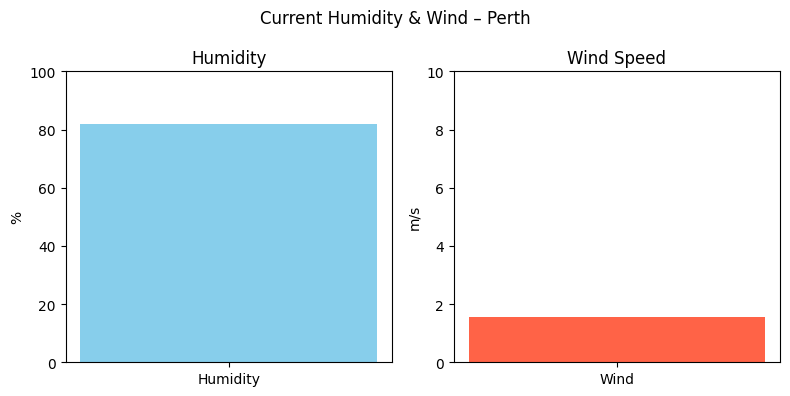

In [105]:
def create_wind_humidity_visualisation(weather_data, output_type='display', theme=None):
    if not weather_data or "current" not in weather_data:
        print("⚠️ Invalid data.")
        return None

    loc = weather_data["location"]["name"]
    cur = weather_data["current"]
    humidity = cur.get("humidity", 0)
    wind = cur.get("wind_speed", 0)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Humidity
    axs[0].bar(["Humidity"], [humidity], color="skyblue")
    axs[0].set_ylim(0, 100)
    axs[0].set_ylabel("%")
    axs[0].set_title("Humidity")

    # Wind Speed
    axs[1].bar(["Wind"], [wind], color="tomato")
    axs[1].set_ylim(0, max(10, wind + 2))
    axs[1].set_ylabel("m/s")
    axs[1].set_title("Wind Speed")

    fig.suptitle(f"Current Humidity & Wind – {loc}")
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show(block=False); plt.close(fig); return None

# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_wind_humidity_visualisation(data)

### 24 Hour Temperature Visualisation

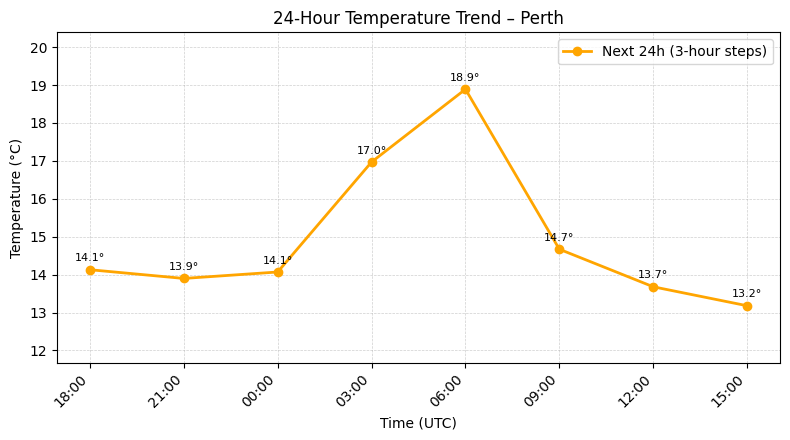

In [103]:
import matplotlib.pyplot as plt
from datetime import datetime

def create_hourly_temperature_visualisation(weather_data, output_type='display', theme=None):
    """
    Create a 24-hour temperature trend line chart using hourly forecast data.
    Line chart for next 24h temperatures (every 3h) with legend and padding.

    Args:
        weather_data (dict): Processed weather data from get_weather_data().
            Expected structure:
                weather_data["hourly_24h"] = [
                    {"dt":"YYYY-MM-DD HH:MM:SS","temp":float,"description":str}, ...
                ]
        output_type (str): 'display' to show the chart, or 'figure' to return the Matplotlib figure.

    Returns:
        If output_type == 'figure': returns a matplotlib.figure.Figure
        Otherwise: displays the chart and returns None
    """
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print("⚠️ Cannot create visualisation: missing or invalid weather data.")
        return None

    hourly = weather_data.get("hourly_24h")
    if not hourly:
        print("ℹ️ Hourly data unavailable; try include_hourly_24h=True when fetching.")
        return None

    title_location = weather_data.get("location", {}).get("name") or weather_data.get("location", "") or "Selected Location"

    times, temps = [], []
    for row in hourly:
        dt_text, t = row.get("dt"), row.get("temp")
        if not dt_text or t is None:
            continue
        try:
            label = datetime.strptime(dt_text, "%Y-%m-%d %H:%M:%S").strftime("%H:%M")
        except Exception:
            label = dt_text
        times.append(label); temps.append(float(t))

    if not times or not temps:
        print("ℹ️ No valid hourly temperature data found.")
        return None

    fig, ax = plt.subplots(figsize=(8, 4.5))
    color = apply_theme_color(theme, "hourly_line", "orange")
    ax.plot(times, temps, marker='o', linewidth=2, color=color, label="Next 24h (3-hour steps)")
    ax.set_title(f"24-Hour Temperature Trend – {title_location}")
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Temperature (°C)")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=apply_theme_color(theme, "grid_alpha", 0.6))
    ax.legend(loc="best")

    for x, y in zip(times, temps):
        ax.annotate(f"{y:.1f}°", xy=(x, y), xytext=(0, 6), textcoords="offset points", ha="center", fontsize=8)

    ymin, ymax = min(temps), max(temps)
    if ymin == ymax: ymin -= 2; ymax += 2
    ax.set_ylim(ymin - 1.5, ymax + 1.5)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if output_type == 'figure': return fig
    plt.show(block=False); plt.close(fig); return None

# Sample test input using existing data dict:
data = get_weather_data("Perth,AU", forecast_days=3)
create_hourly_temperature_visualisation(data)

## 🤖 Natural Language Processing

In [109]:
import re
from datetime import datetime, timezone, timedelta

def parse_weather_question(question: str) -> dict:
    """
    Parse a natural language weather question into structured intent.

    Extracts:
      - attribute: one of {"temperature","rain","wind","humidity","conditions"}
      - time_period: {"today","tomorrow","next_n_days"} (+ n if relevant)
      - forecast_days: int (1..5) best-effort for the attribute/time
      - location: string or None if not specified
      - question_type: {"yesno","value","summary"} crude classification
      - raw: original question (for logging/debug)

    Examples:
      "Will it rain tomorrow in Perth?" ->
        {"attribute":"rain","time_period":"tomorrow","forecast_days":2,
         "location":"Perth","question_type":"yesno"}

      "What's the temperature for the next 3 days in Sydney, AU?" ->
        {"attribute":"temperature","time_period":"next_n_days","n":3,
         "forecast_days":3,"location":"Sydney, AU","question_type":"value"}
    """
    if not isinstance(question, str) or not question.strip():
        return {"error": "Empty question.", "raw": question}

    q_raw = question.strip()
    q = q_raw.lower()

    # ---- attribute detection ----
    attr = None
    if re.search(r"\b(temp|temperature|hot|cold|warm|cool)\b", q):
        attr = "temperature"
    elif re.search(r"\b(rain|rainy|shower|precip|umbrella)\b", q):
        attr = "rain"
    elif re.search(r"\b(wind|windy|gust)\b", q):
        attr = "wind"
    elif re.search(r"\b(humidity|humid)\b", q):
        attr = "humidity"
    elif re.search(r"\b(weather|forecast|clear|cloud|sunny|storm|snow|overcast)\b", q):
        attr = "conditions"
    else:
        # default to conditions if completely unspecified
        attr = "conditions"

    # ---- time period detection ----
    time_period = None
    n_days = None

    if re.search(r"\btoday\b", q):
        time_period = "today"
    elif re.search(r"\btomorrow\b", q):
        time_period = "tomorrow"
    else:
        # next N days
        m = re.search(r"\bnext\s+(\d+)\s*(day|days)\b", q)
        if m:
            n_days = max(1, min(int(m.group(1)), 5))
            time_period = "next_n_days"
        elif re.search(r"\bnext\s+few\s+days\b", q):
            n_days = 3
            time_period = "next_n_days"
        elif re.search(r"\bthis\s+week(end)?\b", q):
            # keep it simple for v1: map to 3 days
            n_days = 3
            time_period = "next_n_days"

    # default time period if none found
    if not time_period:
        # yes/no questions without explicit time often imply "today" or "soon"
        time_period = "today"

    # choose forecast_days (for API/daily usage)
    if time_period == "today":
        forecast_days = 1
    elif time_period == "tomorrow":
        forecast_days = 2  # fetch at least 2 so index 1 exists if needed
    elif time_period == "next_n_days":
        forecast_days = n_days or 3
    else:
        forecast_days = 3

    forecast_days = max(1, min(int(forecast_days), 5))

    # ---- question type ----
    question_type = "value"
    if re.match(r"\s*(will|is|are|do|does|should|can|could)\b", q):
        question_type = "yesno"
    elif re.search(r"\bforecast|weather\b", q) and attr == "conditions":
        question_type = "summary"

    # ---- location extraction ----
    # 1) common pattern: "in <location...>"
    loc = None
    m_in = re.search(r"\bin\s+([a-z0-9 .,\-']+)$", q, flags=re.I)
    if not m_in:
        m_in = re.search(r"\bin\s+([a-z0-9 .,\-']+?)(\?|\!|\.|$)", q, flags=re.I)
    if m_in:
        loc = m_in.group(1).strip(" ?!.,")
    else:
        # 2) pattern: "... for <location>"
        m_for = re.search(r"\bfor\s+([a-z0-9 .,\-']+?)(\?|\!|\.|$)", q, flags=re.I)
        if m_for:
            loc = m_for.group(1).strip(" ?!.,")
        else:
            # 3) trailing capitalized phrase heuristic (very light)
            #    e.g., "What about Perth, AU?"
            m_tail = re.search(r"([A-Z][A-Za-z .,'\-]+(?:,[ ]?[A-Z]{2})?)\s*[?!.]*$", q_raw)
            if m_tail and len(m_tail.group(1).split()) <= 4:
                loc = m_tail.group(1).strip()

    # normalize a bit
    if loc:
        loc = re.sub(r"\s+", " ", loc)

    return {
        "attribute": attr,
        "time_period": time_period,
        "n": n_days,
        "forecast_days": forecast_days,
        "location": loc,          # may be None; caller can provide default
        "question_type": question_type,
        "raw": q_raw
    }

In [110]:
# Activity-aware parser (wrapper)

def parse_weather_question_with_activities(question: str) -> dict:
    """
    Wrapper around parse_weather_question() that also detects activity intent,
    e.g. 'hiking'. If hiking is detected, ensures at least 3 forecast days so
    we can compare days for a recommendation.
    """
    # Use your existing base parser first
    base = parse_weather_question(question)
    if not isinstance(base, dict) or "error" in base:
        return base

    q = (question or "").lower()

    # ---- Detect activities (you can add more later) ----
    activity = None
    if re.search(r"\b(hik(e|ing))\b", q):
        activity = "hiking"
    elif re.search(r"\bgood\s+for\s+(hiking)\b", q):
        activity = "hiking"

    # You can add more activities here (beach, picnic, etc.), but only 'hiking'
    # is implemented in recommend_activity() for now.

    if activity:
        base["activity"] = activity
        # Make sure we fetch enough days to compare (min 3, max 5)
        fd = base.get("forecast_days", 3)
        base["forecast_days"] = max(3, min(5, int(fd or 3)))

        # If user asked "tomorrow good for hiking", keep time_period but still fetch ≥3
        # The recommender will still show a multi-day comparison.
    return base

In [111]:
def generate_weather_response(parsed_question: dict, weather_data: dict) -> str:
    """
    Turn parsed intent + fetched weather_data into a natural-language reply.

    Expects weather_data from get_weather_data(). Handles:
      - attribute-specific phrasing (temperature, rain, wind, humidity, conditions)
      - time periods (today, tomorrow, next_n_days)
      - missing data / provider errors gracefully
    """
    # ---- guard rails ----
    if not isinstance(parsed_question, dict):
        return "Sorry, I couldn't understand the question format."
    if not isinstance(weather_data, dict):
        return "Sorry, I couldn't access weather information at the moment."

    # provider/UI error
    if "error" in weather_data:
        msg = weather_data["error"].get("message", "An unknown error occurred.")
        hint = weather_data["error"].get("hint")
        return f"Sorry, I couldn't retrieve the weather. {msg}" + (f" Hint: {hint}" if hint else "")

    attr = parsed_question.get("attribute") or "conditions"
    period = parsed_question.get("time_period") or "today"
    n_days = parsed_question.get("n")
    qtype = parsed_question.get("question_type", "value")

    loc_name = weather_data.get("location", {}).get("name") or weather_data.get("location") or "the selected location"
    current = weather_data.get("current") or {}
    daily = weather_data.get("daily") or []

    # Helper: pick day index
    # Note: your 'daily' list is the *future* days (UTC), often starting from tomorrow.
    idx_tomorrow = 0 if len(daily) >= 1 else None

    def fmt_deg(v):
        try: return f"{float(v):.1f}°C"
        except: return "N/A"

    def fmt_pct(v):
        try: return f"{float(v):.0f}%"
        except: return "N/A"

    # ---- handle each attribute ----
    if period == "today":
        # TODAY: lean on 'current' snapshot + a hint from first daily if available
        if attr == "temperature":
            cur = current.get("temp")
            desc = current.get("description", "").lower()
            return f"Right now in {loc_name} it's {fmt_deg(cur)} and {desc or '—'}."

        elif attr == "rain":
            # Use next day POP if today's POP not available; otherwise infer from description
            if daily:
                pop = daily[0].get("pop", 0.0)
                answer = f"The chance of rain today in {loc_name} is about {fmt_pct(pop)}."
            else:
                desc = (current.get("description") or "").lower()
                likely = "likely" if any(k in desc for k in ["rain","shower"]) else "unlikely"
                answer = f"Rain is {likely} today in {loc_name} based on current conditions."
            if qtype == "yesno":
                return ("Yes" if (daily and daily[0].get("pop",0)>=50) else "Probably not") + f" — {answer}"
            return answer

        elif attr == "wind":
            ws = current.get("wind_speed")
            return f"Current wind in {loc_name} is {ws:.1f} m/s." if ws is not None else f"Wind data isn't available for {loc_name} right now."

        elif attr == "humidity":
            h = current.get("humidity")
            return f"Humidity in {loc_name} is {h}%." if h is not None else f"Humidity data isn't available for {loc_name} right now."

        else:  # conditions
            desc = current.get("description")
            if desc:
                return f"Currently in {loc_name}: {desc}, {fmt_deg(current.get('temp'))}."
            return f"Sorry, I couldn't determine current conditions for {loc_name}."

    elif period == "tomorrow":
        if idx_tomorrow is None:
            return f"Sorry, I don't have a forecast for tomorrow in {loc_name}."

        d = daily[idx_tomorrow]
        date = d.get("date", "tomorrow")
        if attr == "temperature":
            return (f"Tomorrow ({date}) in {loc_name}: {fmt_deg(d.get('temp_avg'))} on average "
                    f"(min {fmt_deg(d.get('temp_min'))}, max {fmt_deg(d.get('temp_max'))}).")
        elif attr == "rain":
            pop = d.get("pop", 0.0)
            if qtype == "yesno":
                return ("Yes" if pop >= 50 else "Probably not") + f". Chance of rain tomorrow ({date}) in {loc_name} is {fmt_pct(pop)}."
            return f"Chance of rain tomorrow ({date}) in {loc_name} is {fmt_pct(pop)}."
        elif attr == "wind":
            # We don't have daily wind in the free 2.5 feed; give a helpful note
            return (f"I don’t have reliable daily wind speeds for tomorrow in {loc_name} with this data source. "
                    f"You can check current wind ({current.get('wind_speed','N/A')} m/s) or the 24-hour chart.")
        elif attr == "humidity":
            return (f"I don’t have daily humidity for tomorrow in {loc_name} from this feed. "
                    f"Current humidity is {current.get('humidity','N/A')}%.")
        else:
            return f"Tomorrow ({date}) in {loc_name} looks {d.get('description','—').lower()} around {fmt_deg(d.get('temp_avg'))}."

    elif period == "next_n_days":
        k = max(1, min(int(n_days or 3), 5))
        if not daily:
            return f"Sorry, I don’t have a multi-day forecast for {loc_name}."
        days = daily[:k]
        if attr == "temperature":
            parts = [f"{d['date']}: avg {fmt_deg(d['temp_avg'])} (min {fmt_deg(d['temp_min'])}, max {fmt_deg(d['temp_max'])})" for d in days]
            return f"Next {k} days in {loc_name}:\n- " + "\n- ".join(parts)
        elif attr == "rain":
            parts = [f"{d['date']}: {fmt_pct(d.get('pop',0))}" for d in days]
            return f"Chance of rain over the next {k} days in {loc_name}:\n- " + "\n- ".join(parts)
        elif attr == "wind":
            return (f"I don’t have daily wind forecasts in this feed. "
                    f"Try the 24-hour temperature chart and current wind ({current.get('wind_speed','N/A')} m/s).")
        elif attr == "humidity":
            return (f"I don’t have daily humidity forecasts in this feed. "
                    f"Current humidity is {current.get('humidity','N/A')}% in {loc_name}.")
        else:
            parts = [f"{d['date']}: {d.get('description','—').lower()}, around {fmt_deg(d.get('temp_avg'))}" for d in days]
            return f"Summary for the next {k} days in {loc_name}:\n- " + "\n- ".join(parts)

    # Fallback
    return f"Here’s the current snapshot for {loc_name}: {current.get('summary','N/A')}"

In [112]:
# Activity-aware responder (wrapper)

def generate_weather_response_with_activities(parsed_question: dict, weather_data: dict) -> str:
    """
    If an activity (e.g., 'hiking') is present, return a recommendation summary.
    Otherwise, fall back to your existing generate_weather_response().
    """
    if not isinstance(parsed_question, dict):
        return "Sorry, I couldn't understand the question format."
    if not isinstance(weather_data, dict):
        return "Sorry, I couldn't access weather information at the moment."

    # Handle provider/UI errors first
    if "error" in weather_data:
        msg = weather_data["error"].get("message", "An unknown error occurred.")
        hint = weather_data["error"].get("hint")
        return f"Sorry, I couldn't retrieve the weather. {msg}" + (f" Hint: {hint}" if hint else "")

    activity = (parsed_question or {}).get("activity")

    # If an activity is present, try recommendations
    if activity:
        # Ensure the recommend_activity() helper exists (from the Shared Helpers section)
        if "recommend_activity" in globals():
            days = parsed_question.get("forecast_days", 3)
            loc_name = weather_data.get("location", {}).get("name") or "this location"

            if activity == "hiking":
                return recommend_activity(weather_data, activity="hiking", days=days)
            else:
                # Not implemented activities fall back with a friendly note
                return (f"I don’t have a model for {activity} yet. "
                        f"Here’s the current snapshot for {loc_name}: "
                        f"{weather_data.get('current', {}).get('summary','N/A')}")
        else:
            # Safety net if helper wasn’t added
            return ("Activity recommendations are not configured yet. "
                    "Please add recommend_activity() in the Shared Helpers section.")

    # No activity intent → use your existing natural-language generator
    return generate_weather_response(parsed_question, weather_data)

In [ ]:
# Sample test

# 1) Parse the user’s question
pq = parse_weather_question("Will it rain tomorrow in Perth?")

# 2) Decide the location & days for fetching (use default if None)
loc = pq.get("location") or "Perth,AU"
days = pq.get("forecast_days", 3)

# 3) Fetch weather (your existing function)
data = get_weather_data(loc, forecast_days=days)

# 4) Generate response
reply = generate_weather_response(pq, data)
print(reply)

Yes. Chance of rain tomorrow (2025-10-04) in Perth is 92%.


## 🧭 User Interface

In [124]:
# User Interface (pyinputplus)
import pyinputplus as pyip
import json
from textwrap import dedent

# ---- Global default (change if you like) ----
DEFAULT_LOCATION = "Perth,AU"

# ---- Small UI helpers ----
def ui_header(title: str):
    print("\n" + "=" * 60)
    print(title)
    print("=" * 60)

def ui_info(msg: str):
    print(f"ℹ️  {msg}")

def ui_ok(msg: str):
    print(f"✅ {msg}")

def ui_warn(msg: str):
    print(f"⚠️ {msg}")

def ui_err(msg: str):
    print(f"❌ {msg}")

def ui_press_enter(message="\nPress Enter to continue..."):
    input(message)

# ---- Common city short forms or aliases ----
COMMON_CITY_ALIASES = {
    "melb": "Melbourne,AU",
    "syd": "Sydney,AU",
    "per": "Perth,AU",
    "jak": "Jakarta,ID",
    "lon": "London,UK",
    "nyc": "New York,US"
}

def normalize_city_input(user_input):
    """
    Expand short or partial city inputs into full valid names.
    Example: 'melb' -> 'Melbourne,AU'
    """
    cleaned = user_input.strip().lower().replace(".", "").replace(",", "")
    for short, full in COMMON_CITY_ALIASES.items():
        if cleaned.startswith(short):
            print(f"💡 Interpreting '{user_input}' as '{full}'")
            return full
    return user_input

# ---- Input helpers with validation ----
def ui_get_city(default_location=DEFAULT_LOCATION):
    """
    Ask the user for a city name with a clearer and friendlier prompt.
    """
    print("\n🌍 You can type just the city name (e.g., 'Perth') or include a country code (e.g., 'Sydney,AU').")
    print("If you just press Enter, the default location will be used.")

    city = pyip.inputStr(
        prompt=f"Which city would you like to check the weather for? [Default: {default_location}]: ",
        blank=True
    ).strip()

    if not city:
        ui_info(f"No city entered. Using default: {default_location}")
        city = default_location

    # Add this line before returning
    city = normalize_city_input(city)

    return city


def ui_get_days(default=3):
    print("\n📅 Great! Now let's choose how many days of forecast you'd like to see.")
    print("Tip: Enter 1 for today only, or up to 5 for a full 5-day forecast.\n")
    days = pyip.inputInt(
        prompt=f"How many days would you like? [Default: {default}]: ",
        min=1, max=5, blank=True
    )
    return days or default

# ---- Pretty text renderers (no plotting) ----
def ui_show_current_summary(data: dict):
    loc = data["location"]["name"]
    print(f"\n— Current in {loc} —")
    print(data["current"]["summary"])
    # optional extras
    tz = data["location"].get("timezone_offset_seconds", 0)
    print(f"Timezone offset: {tz//3600:+d}h")

def ui_show_daily_table(data: dict):
    print("\n— Daily Forecast —")
    if not data.get("daily"):
        ui_info("No daily forecast available.")
        return
    for d in data["daily"]:
        print(f"{d['date']}: {d['description']} | avg {d['temp_avg']}°C "
              f"(min {d['temp_min']}°C, max {d['temp_max']}°C) | rain {d['pop']}%")

import re

def is_city_match(requested_city, api_result):
    """
    Check whether the city returned by the API matches what the user typed.
    Allows small differences (like commas, spaces, case, or short country codes).
    Rejects vague or ultra-short inputs like 'mel' or 'lon'.
    """
    if not api_result or "location" not in api_result:
        return False

    api_name = (api_result["location"].get("name") or "").strip().lower()
    api_country = (api_result["location"].get("country") or "").strip().lower()
    req_name = requested_city.strip().lower()

    # --- normalize both sides ---
    # remove commas, multiple spaces, etc.
    req_name = re.sub(r"[^a-z0-9 ]+", "", req_name)
    api_name = re.sub(r"[^a-z0-9 ]+", "", api_name)

    # also handle when user includes country code
    if api_country and api_country in req_name:
        req_name = req_name.replace(api_country, "").strip()

    # reject extremely short ambiguous inputs
    if len(req_name) < 3:
        return False

    # exact match
    if req_name == api_name:
        return True

    # partial match tolerance
    if api_name.startswith(req_name) or req_name.startswith(api_name):
        return True

    # otherwise, no match
    return False

# ---- Dashboard flow (fetch once, then show multiple outputs) ----
def ui_dashboard():
    ui_header("Weather Dashboard")
    city = ui_get_city()
    ui_info(f"Checking if '{city}' is a valid city...")
    test_data = get_weather_data(city, forecast_days=1, include_hourly_24h=False)

    # ---- Step 2b: Validate API response ----
    if not isinstance(test_data, dict) or "error" in test_data:
        ui_err(test_data.get("error", {}).get("message", "Unable to fetch weather."))
        hint = test_data.get("error", {}).get("hint")
        if hint:
            ui_info(hint)

        retry = pyip.inputYesNo("Would you like to try another city? (yes/no): ")
        if retry == "yes":
            return ui_dashboard()  # restart cleanly
        else:
            ui_info("Returning to main menu...")
            return

# ---- Step 2c: Check if the API city actually matches user input ----
    if not is_city_match(city, test_data):
        found_name = test_data.get("location", {}).get("name", "Unknown")
        ui_warn(f"Your input '{city}' matched another city called '{found_name}'. Please enter the full city name or include the country code.")

        retry = pyip.inputYesNo("Would you like to try another city? (yes/no): ")
        if retry == "yes":
            return ui_dashboard()  # restart this function cleanly
        else:
            ui_info("Returning to main menu...")
            return

    ui_ok(f"City '{city}' found and validated successfully!")
    days = ui_get_days(default=5)
    ui_info(f"Fetching {days}-day forecast for {city} ...")
    data = get_weather_data(city, forecast_days=days, include_hourly_24h=True)
    ui_ok("Data retrieved successfully.")
    ui_show_current_summary(data)
    ui_show_daily_table(data)

    # Offer quick visuals
    while True:
        print("\nWhat would you like to visualise?")
        choice = pyip.inputMenu(
            ["Temperature Trend", "Precipitation Probability", "Temperature Range (Min–Max)",
             "Wind & Humidity (Current)", "24-Hour Temperature", "Back to Main Menu"],
            numbered=True
        )

        ui_info(f"You chose: {choice}")  # confirmation line

        try:
            if choice == "Temperature Trend":
                create_temperature_visualisation(data)
            elif choice == "Precipitation Probability":
                create_precipitation_visualisation(data)
            elif choice == "Temperature Range (Min–Max)":
                create_temperature_range_visualisation(data)
            elif choice == "Wind & Humidity (Current)":
                create_wind_humidity_visualisation(data)
            elif choice == "24-Hour Temperature":
                create_hourly_temperature_visualisation(data)
            elif choice == "Back to Main Menu":
                ui_info("Returning to Main Menu...")
                break  # stop looping and return to main menu

            # add pause before showing the menu again
            import time
            time.sleep(0.5)
            plt.close("all")
            print("\n✅ Chart displayed successfully.")
            print("You can view another chart or go back to the main menu.")
            print("\n" + "-" * 60 + "\n")
            time.sleep(0.5)

        except Exception as e:
            ui_warn(f"Couldn't render the chart: {e}")
            print("\n" + "-" * 60 + "\n")
            time.sleep(0.5)

# ---- Quick fetch (debug/inspection) ----
def ui_quick_fetch():
    ui_header("Quick Fetch (Debug)")
    city = ui_get_city()
    days = ui_get_days(default=3)
    ui_info(f"Fetching {days}-day forecast for {city} ...")
    data = get_weather_data(city, forecast_days=days, include_hourly_24h=True)
    if not isinstance(data, dict) or "error" in data:
        ui_err(data.get("error", {}).get("message", "Unable to fetch weather."))
        hint = data.get("error", {}).get("hint")
        if hint:
            ui_info(hint)
        ui_press_enter()
        return
    print("\nPreview:")
    print(json.dumps(data, indent=2)[:1200], "...")
    ui_press_enter()

# ---- Chat mode ----
def ui_chat():
    ui_header("Chat Mode")

    # ---- Choose the best available parser/response pair ----
    parser_fn = None
    responder_fn = None

    # Prefer activity-aware wrappers if present
    if 'parse_weather_question_with_activities' in globals():
        parser_fn = globals()['parse_weather_question_with_activities']
    elif 'parse_weather_question' in globals():
        parser_fn = globals()['parse_weather_question']

    if 'generate_weather_response_with_activities' in globals():
        responder_fn = globals()['generate_weather_response_with_activities']
    elif 'generate_weather_response' in globals():
        responder_fn = globals()['generate_weather_response']

    if not (parser_fn and responder_fn):
        ui_warn("Natural language features are not available yet in this notebook.")
        ui_press_enter()
        return

    # ---- Friendly greeting ----
    print("🌸 Hi there! I’m Aurora — your Weather Wise chatbot assistant ☁️")
    print("You can ask me about:")
    print("• 🌤  Weather forecasts (temperature, rain, wind, humidity)")
    print("• 🥾 Activity recommendations (like hiking, beach trips, or picnics)")
    print("• 🗓️  Event planning — I can even suggest the best day for your activity!")
    print("💡 Tip: Please include a city or location in your question so I can fetch accurate results.")
    print("Examples:")
    print("• Will it rain tomorrow in Sydney?")
    print("• Is tomorrow good for hiking in Perth?")
    print("• Show temperature for the next 3 days in Melbourne")
    print(f"If you forget, I'll use your default location ({DEFAULT_LOCATION}).")
    print("Type 'back' anytime to return to the main menu.\n")

    default_loc = DEFAULT_LOCATION

    # ---- Conversation loop ----
    while True:
        q = pyip.inputStr("🧑 You: ").strip()
        if q.lower() in {"back", "exit", "quit"}:
            print("👋 Aurora: Goodbye! Stay safe and enjoy your day ☀️")
            break

        parsed = parser_fn(q)
        if not isinstance(parsed, dict) or "error" in parsed:
            ui_warn(parsed.get("error", "Sorry, I couldn't understand that."))
            continue

        loc = parsed.get("location") or default_loc
        days = parsed.get("forecast_days", 3)

        data = get_weather_data(loc, forecast_days=days, include_hourly_24h=True)
        if not isinstance(data, dict) or "error" in data:
            msg = (data.get("error", {}) or {}).get("message", f"Couldn't fetch weather for '{loc}'.")
            print(f"🙁 Aurora: {msg}")
            hint = (data.get("error", {}) or {}).get("hint")
            if hint:
                print(f"ℹ️  {hint}")
            continue

        # ---- Primary answer (activity-aware if supported) ----
        answer = responder_fn(parsed, data)
        print(f"💬 Aurora: {answer}\n")

        # ---- If an activity is present, show a recommendation summary and a calendar suggestion ----
        activity = parsed.get("activity")
        if activity and 'recommend_activity' in globals():
            try:
                # 1) Text summary (e.g., hiking)
                print(recommend_activity(data, activity=activity, days=days))

                # 2) Calendar suggestion: pick best day if available
                if 'score_hiking_day' in globals() and 'is_day_good_for_event' in globals() and 'add_event_placeholder' in globals():
                    best_day = None
                    best_score = -1
                    for drow in data.get("daily", []):
                        # currently only hiking has a scorer, extend if you add more activities
                        score, _why = score_hiking_day(drow)
                        if score > best_score:
                            best_score, best_day = score, drow["date"]
                    if best_day:
                        ok, msg = is_day_good_for_event(data, target_date=best_day, activity=activity)
                        print(f"\n📅 Calendar suggestion (best day: {best_day}):")
                        print(msg)
                        print(add_event_placeholder(f"{activity.title()} Day", best_day, data["location"]["name"]))
                print()  # space after the activity block
            except Exception as e:
                ui_warn(f"Couldn't generate activity recommendation: {e}")

        # ---- Optional contextual visualisation for non-activity queries ----
        # (Keep visuals for weather attributes; activity responses already include a summary)
        attr = (parsed.get("attribute") or "").lower()
        period = parsed.get("time_period")
        try:
            if not activity:
                if "temperature" in attr and period == "next_n_days":
                    create_temperature_visualisation(data)
                elif "temperature" in attr and period in {"today", "tomorrow"}:
                    create_temperature_range_visualisation(data)
                elif "rain" in attr:
                    create_precipitation_visualisation(data)
                elif "wind" in attr or "humidity" in attr:
                    create_wind_humidity_visualisation(data)
                elif period == "today" and "hourly_24h" in data:
                    create_hourly_temperature_visualisation(data)
        except Exception as e:
            ui_warn(f"Couldn't render a related chart: {e}")

        import time, matplotlib.pyplot as plt
        time.sleep(0.5)     # give the frontend time to draw the figure
        plt.close("all")    # avoid stacking figures / blocking inputs
        print("\n✅ Chart displayed. Ask me another question, or type 'back' to return.")
        print("-" * 60)

# ---- Main menu / flow ----
def run_app():
    while True:
        ui_header("Weather Wise — Main Menu")
        choice = pyip.inputMenu(
            ["Dashboard", "Chat", "Quick Fetch (Debug)", "Settings", "Exit"],
            numbered=True
        )
        if choice == "Dashboard":
            ui_dashboard()
        elif choice == "Chat":
            ui_chat()
        elif choice == "Quick Fetch (Debug)":
            ui_quick_fetch()
        elif choice == "Settings":
            ui_settings()
        else:
            ui_info("Goodbye!")
            break

def ui_settings():
    global DEFAULT_LOCATION
    ui_header("Settings")
    print(f"Current default location: {DEFAULT_LOCATION}")
    new_loc = pyip.inputStr("Set new default location (blank to keep current): ", blank=True).strip()
    if new_loc:
        DEFAULT_LOCATION = new_loc
        ui_ok(f"Default location set to: {DEFAULT_LOCATION}")
    else:
        ui_info("Default location unchanged.")
    ui_press_enter()


Weather Wise — Main Menu
Please select one of the following:
1. Dashboard
2. Chat
3. Quick Fetch (Debug)
4. Settings
5. Exit
2

Chat Mode
🌸 Hi there! I’m Aurora — your Weather Wise chatbot assistant ☁️
You can ask me about:
• 🌤  Weather forecasts (temperature, rain, wind, humidity)
• 🥾 Activity recommendations (like hiking, beach trips, or picnics)
• 🗓️  Event planning — I can even suggest the best day for your activity!
💡 Tip: Please include a city or location in your question so I can fetch accurate results.
Examples:
• Will it rain tomorrow in Sydney?
• Is tomorrow good for hiking in Perth?
• Show temperature for the next 3 days in Melbourne
If you forget, I'll use your default location (Perth,AU).
Type 'back' anytime to return to the main menu.

🧑 You: what is the temperature tomorrow in Melbourne?
💬 Aurora: Tomorrow (2025-10-04) in Melbourne: 26.8°C on average (min 26.3°C, max 27.2°C).



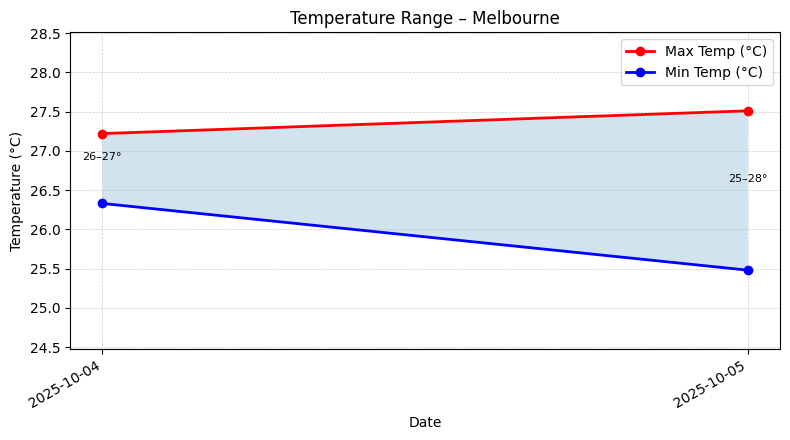


✅ Chart displayed. Ask me another question, or type 'back' to return.
------------------------------------------------------------
🧑 You: what about raining in melbourne?
💬 Aurora: Currently in Melbourne: Mist, 26.9°C.



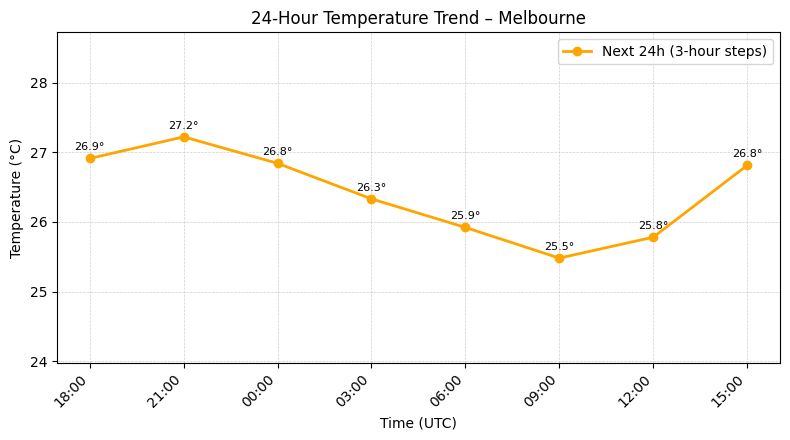


✅ Chart displayed. Ask me another question, or type 'back' to return.
------------------------------------------------------------
🧑 You: back
👋 Aurora: Goodbye! Stay safe and enjoy your day ☀️

Weather Wise — Main Menu
Please select one of the following:
1. Dashboard
2. Chat
3. Quick Fetch (Debug)
4. Settings
5. Exit
5
ℹ️  Goodbye!


In [125]:
# Launch UI
run_app()

## 🧩 Main Application Logic

In [ ]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    pass

## 🧪 Testing and Examples

In [ ]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.